
# Regulatory Risk Level Prediction





In [1]:
from google.colab import files
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_auc_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle
from sklearn import __version__ as sklearn_version


In [2]:
uploaded = files.upload()

Saving Synthetic_Dataset.xlsx to Synthetic_Dataset.xlsx


In [222]:
df = pd.read_excel('Synthetic_Dataset.xlsx')
df = df.fillna('None') ## to change NaN values to "None"

In [223]:
df.head()

,annual_clients,infraction_type,infraction_timeline,public_complaints,sentiment_analysis,inspection_result
0,92,Major,None,Major,Flagged,Pass
1,258,Major,Within past 1-3 years,Minor,Flagged,Pass
2,649,Major,None,None,Flagged,Pass
3,654,None,None,Major,Flagged,None
4,735,Minor,None,Major,None,Fail


In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   annual_clients       5000 non-null   int64 
 1   infraction_type      5000 non-null   object
 2   infraction_timeline  5000 non-null   object
 3   public_complaints    5000 non-null   object
 4   sentiment_analysis   5000 non-null   object
 5   inspection_result    5000 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


# Defining and applying a function to calculate risk score based on the prototype



In [70]:
def calculate_risk_score(row):
  score = 0

  # Number of clients served annually

  if row['annual_clients']<200:
    score+=1
  elif row['annual_clients']<=500:
    score+=2
  else:
    score+=3

  # Past infraction history type

  if row['infraction_type'] =='None':
    score+=1
  elif row['infraction_type'] == 'Minor':
    score+=2
  elif row['infraction_type'] == 'Major':
    score+=3

   # Past infraction history timeline

  if row['infraction_timeline'] == 'None':
    score+=1
  elif row['infraction_timeline'] == 'Within past year':
    score+=2
  elif row['infraction_timeline'] == 'Within past 1-3 years':
    score+=3

  # Public complaints in last quarter

  if row['public_complaints'] == 'None':
    score+=1
  elif row['public_complaints'] == 'Minor':
    score+=2
  elif row['public_complaints'] == 'Major':
    score+=3

  # Quarterly public sentiment analysis

  if row['sentiment_analysis'] == 'None':
    score+=1
  elif row['sentiment_analysis'] == 'Flagged':
    score+=2
  elif row['sentiment_analysis'].empty():
    score+=3

  # Previous inspection results

  if row['inspection_result'] == 'Pass':
    score+=1
  elif row['inspection_result'] == 'Fail':
    score+=2
  else:
    score+=3
  return score


In [225]:
# Calculate risk scores and adding to dataframe

df['Risk_Score']=df.apply(calculate_risk_score,axis=1)

In [7]:
df['Risk_Score'].value_counts()

Risk_Score
12    1039
11     895
13     874
10     666
14     602
9      323
15     306
8      138
16     101
7       37
17      13
6        6
Name: count, dtype: int64

# Defining and applying a function to calculate Risk Level based on Risk Score

In [72]:
def assign_risk_level(score):
  if score <= 7 :
    return 'Low'
  if score <= 12:
    return 'Moderate'
  else:
    return 'High'

In [226]:
# Adding Risk Level to dataframe

df['Risk_Level']=df['Risk_Score'].apply(assign_risk_level)

### Distribution of risk_level classes

In [10]:
risk_level_summary = df['Risk_Level'].value_counts(normalize=True) * 100
print(risk_level_summary)

Risk_Level
Moderate    61.22
High        37.92
Low          0.86
Name: proportion, dtype: float64


# Encoding categorical data to integer

In [227]:
#Encoding manually using the same score value instead of lableEncoder or getDummies

def encoding(item):

        if item in ['Low']:
            return 0
        elif item in ['Pass', 'Moderate', 'None']:
            return 1
        elif item in ['Minor', 'Fail', 'Within past year', 'Flagged', 'High']:
            return 2
        elif item in ['Within past 1-3 years','Major']:
            return 3
        elif item < 200:
            return 1
        elif 200 <= item <= 500:
            return 2
        else:
            return 3



In [228]:
#Encoding all the columns except for risk Score & Risk result
df.iloc[:,:-2]=df.iloc[:,:-2].applymap(encoding)

In [229]:
#Cnverting datatype from object to int
for col in df.columns[:-2]:  # Assuming columns 0 to 6 need to be converted
    df[col] = df[col].apply(int)


#Old Encoding Approach which seems to be wrong when we dn't have diverse records.

In [ ]:
# Encode categorical variables, our columns data are ordinal (High,Medium,Low), so we use Label_Encoders.

#le = LabelEncoder()
#for column in df.columns[:-2]: # Skipped the last two columns (risk_score and risk_level)
 #df[column] = le.fit_transform(df[column])


# Splitting data to train and test for modeling + Data Normalization

In [230]:
# Split data into training and test sets

y = df['Risk_Level']
x = df.drop(columns=['Risk_Level','Risk_Score'])

In [172]:
#Since we used new approach to encode the values this part seems to be useless
"""
scaler = MinMaxScaler()
x_scaled=scaler.fit_transform(x)
cols=x.columns
x=pd.DataFrame(x_scaled,columns=cols)

In [231]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=101)

# Our target is imbalanced , we need to balance it to avoid overfitting.

In [232]:
# Aapplying SMOTE to balance classes

smote = SMOTE(random_state=42)
x_train_resampled,y_train_resampled=smote.fit_resample(x_train,y_train)

# Visualizing target column before and after resampling

Text(0.5, 1.0, 'Proportion of Risk Levels after resampling')

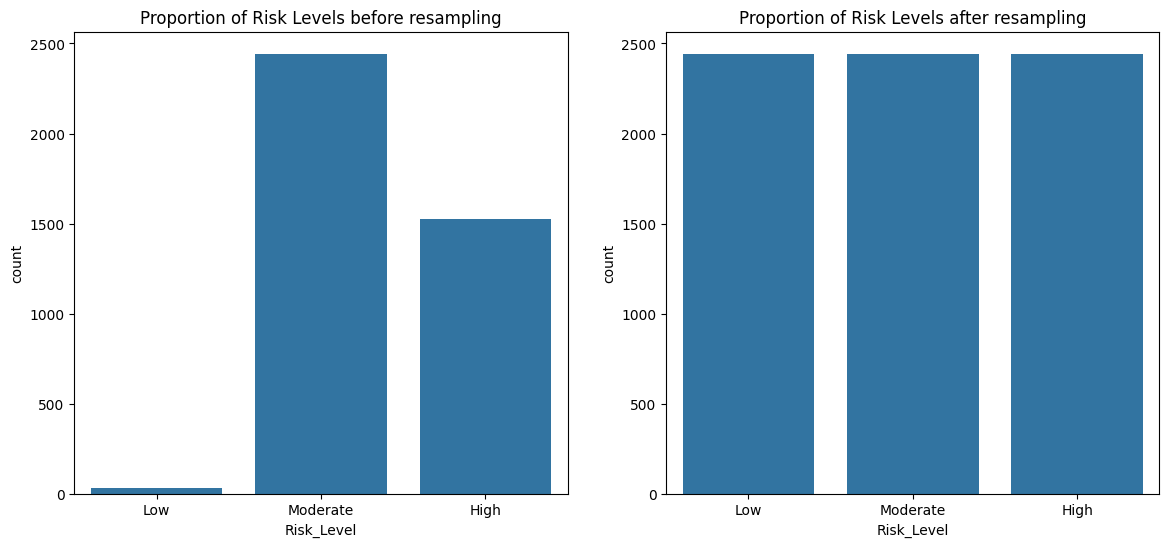

In [234]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
sns.countplot(x=y_train, ax=axs[0],order=['Low', 'Moderate', 'High'])
axs[0].set_title('Proportion of Risk Levels before resampling')

sns.countplot(x=y_train_resampled, ax=axs[1],order=['Low', 'Moderate', 'High'])
axs[1].set_title('Proportion of Risk Levels after resampling')


# For multi_class classification question, we can use classification models such as:
1) RandomForest or
2) LogisticRegression
3) XGBClassifier

---



##Random Forest

In [235]:
# Train Random Forest model with best hyperparameters

rfc = RandomForestClassifier()
parameters = {'min_samples_leaf':[1,2,4],'min_samples_split':[2,5,100],'n_estimators':[10,20,30,100]}
rfc_cv=GridSearchCV(rfc,parameters)
rfc_cv.fit(x_train_resampled,y_train_resampled)
print('tuned hyperparameters: (best parameters)',rfc_cv.best_params_)
print('Best Parameters Accuracy score:', rfc_cv.best_score_)


tuned hyperparameters: (best parameters) {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Parameters Accuracy score: 0.9196672404541569


In [236]:
# Make predictions

y_predict=rfc_cv.predict(x_test)

In [237]:
confusion_matrix(y_test,y_predict)

array([[341,   0,  29],
       [  0,  11,   2],
       [114,   4, 499]])

In [238]:
accuracy_score(y_test,y_predict)

0.851

In [239]:
# Evaluate the model
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

        High       0.75      0.92      0.83       370
         Low       0.73      0.85      0.79        13
    Moderate       0.94      0.81      0.87       617

    accuracy                           0.85      1000
   macro avg       0.81      0.86      0.83      1000
weighted avg       0.87      0.85      0.85      1000



In [240]:
acc=[]
methods=[]
methods.append('Random Forest')
acc.append(accuracy_score(y_test,y_predict))

##Logistic Regression

In [241]:
# Train LogisticRegression
lg = LogisticRegression(max_iter=2000)
parameters={'C':[0.01,0.1,1],'penalty':['l2'],'solver':['lbfgs']}
lg_cv=GridSearchCV(lg,parameters)
lg_cv.fit(x_train_resampled,y_train_resampled)
print('tuned hyperparameters:(Best Parameters)',lg_cv.best_params_)
print('Best Parameters accuracy Score:',lg_cv.best_score_)


tuned hyperparameters:(Best Parameters) {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Parameters accuracy Score: 0.9017999443881817


In [242]:
# Make predictions

y_predict=lg_cv.predict(x_test)

In [243]:
confusion_matrix(y_test,y_predict)

array([[290,   0,  80],
       [  0,  13,   0],
       [ 68,   6, 543]])

In [244]:
accuracy_score(y_test,y_predict)

0.846

In [245]:
# Evaluate the model
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

        High       0.81      0.78      0.80       370
         Low       0.68      1.00      0.81        13
    Moderate       0.87      0.88      0.88       617

    accuracy                           0.85      1000
   macro avg       0.79      0.89      0.83      1000
weighted avg       0.85      0.85      0.85      1000



In [246]:
methods.append('Logistic regression')
acc.append(accuracy_score(y_test,y_predict))

#XGBClassifier

In [247]:
y_train_encoded=y_train_resampled.apply(encoding)
xgb=XGBClassifier()
xgb.fit(x_train_resampled,y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [248]:
y_predict=xgb.predict(x_test)

In [250]:
y_test_encoded=y_test.apply(encoding)

In [251]:
accuracy_score(y_test_encoded,y_predict)

0.843

In [252]:
methods.append('XGBClassifier')
acc.append(accuracy_score(y_test_encoded,y_predict))

# Comparing result of the models and choosing the best performed one

Text(0, 0.5, 'Accuracy')

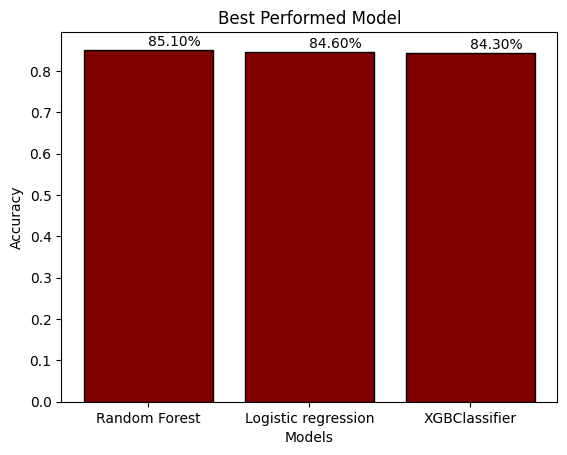

In [253]:
plt.bar(methods,acc,color='maroon',edgecolor='black')
for i in range(len(methods)):
  #plt.text(methods[i],acc[i]+0.01,str(acc[i]*100)+'%')
  plt.text(methods[i], acc[i] + 0.01, f"{acc[i] * 100:.2f}%")
plt.title('Best Performed Model')
plt.xlabel('Models')
plt.ylabel('Accuracy')


# Probability of Risk level Results

In [254]:
y_predict=rfc_cv.predict(x_test)
y_predict_prob=rfc_cv.predict_proba(x_test)

In [255]:
class_labels = rfc_cv.classes_

In [256]:
class_labels

array(['High', 'Low', 'Moderate'], dtype=object)

In [257]:

y_predict_prob

array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0.7, 0. , 0.3],
       ...,
       [0.7, 0. , 0.3],
       [0.4, 0. , 0.6],
       [1. , 0. , 0. ]])

In [258]:
np.set_printoptions(suppress=True, precision=1)

In [259]:
array = np.array(y_predict_prob)*100

In [260]:
array

array([[100. ,   0. ,   0. ],
       [100. ,   0. ,   0. ],
       [ 65.2,   0. ,  34.8],
       ...,
       [ 65.7,   0. ,  34.3],
       [ 41.3,   0. ,  58.7],
       [100. ,   0. ,   0. ]])

In [261]:
column_titles=['High %','Low %','Moderate %']

In [262]:
pd.set_option('display.float_format', '{:.1f}'.format)

In [263]:
df_array=pd.DataFrame(array,columns=column_titles)

In [264]:
df_array[:10]

,High %,Low %,Moderate %
0,100.0,0.0,0.0
1,100.0,0.0,0.0
2,65.2,0.0,34.8
3,100.0,0.0,0.0
4,69.0,0.0,31.0
5,0.0,0.0,100.0
6,0.0,0.0,100.0
7,0.0,0.0,100.0
8,0.0,0.0,100.0
9,71.6,0.0,28.4


# Showing Feature Importance

In [265]:
def plot_feature_importances(importances, feature_names, model_name):
    feature_importances = pd.Series(importances, index=feature_names)
    feature_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='barh')
    plt.title(f'{model_name} Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

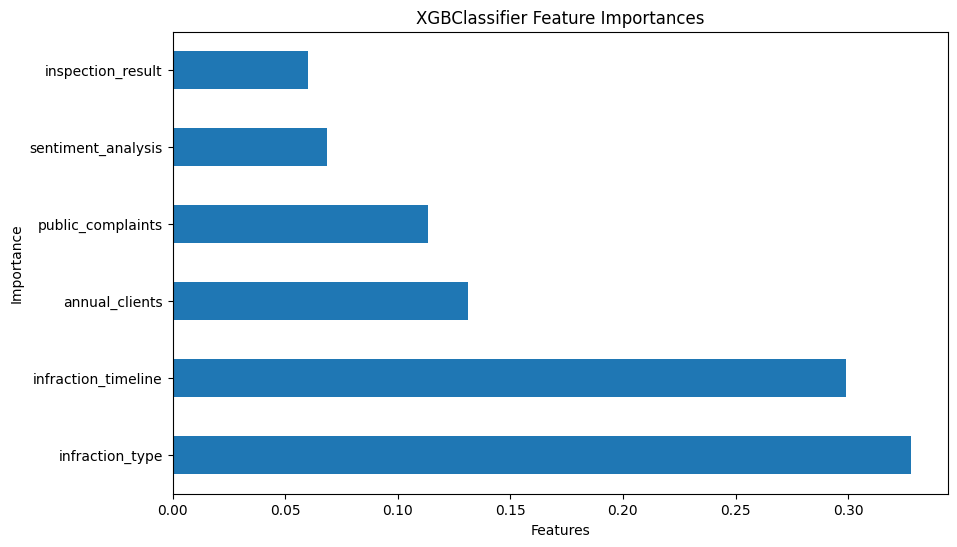

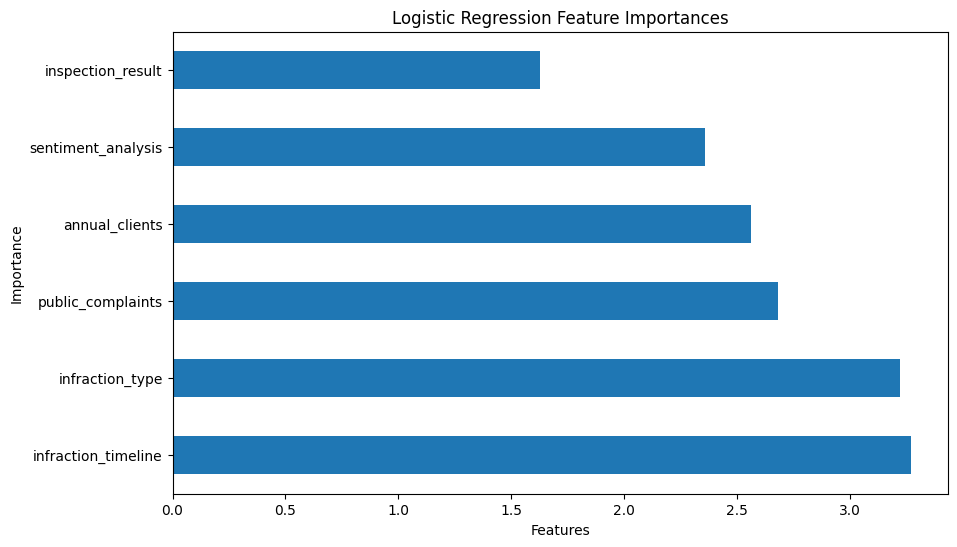

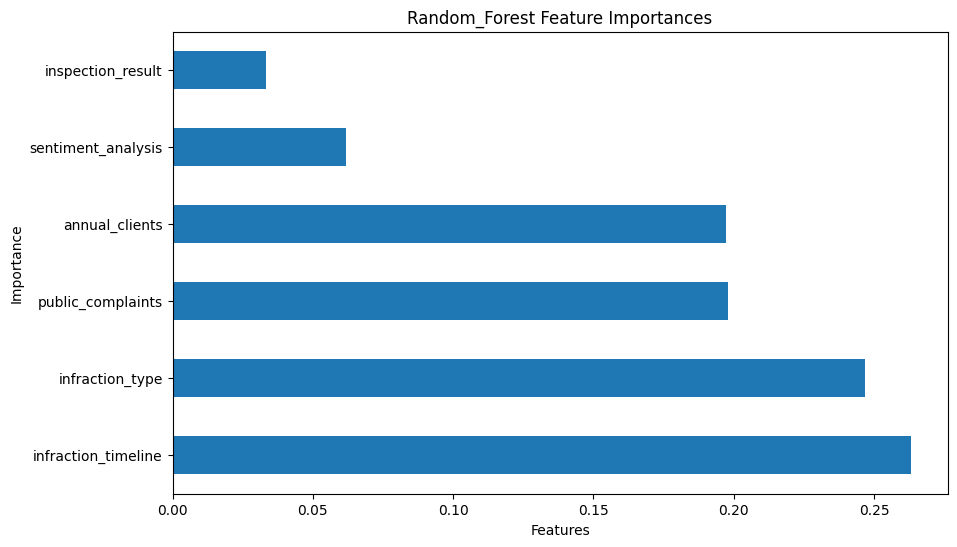

In [266]:

#XGBOOST
plot_feature_importances(xgb.feature_importances_,x.columns,'XGBClassifier')

#Logistic Regression
lg=LogisticRegression(C= 1, penalty='l2', solver='lbfgs',max_iter=2000)
lg.fit(x_train_resampled,y_train_resampled)
coef=lg.coef_
abs_coef=np.abs(coef)
lg_feature_importance = np.mean(abs_coef, axis=0)
plot_feature_importances(lg_feature_importance,x.columns,'Logistic Regression')

#RandomForest Classifier
rfc = RandomForestClassifier(min_samples_leaf=1, min_samples_split= 5, n_estimators= 30)
rfc.fit(x_train_resampled,y_train_resampled)
plot_feature_importances(rfc.feature_importances_,x.columns,'Random_Forest')

#feature_importance=pd.Series(xgb.feature_importances_,x.columns)


# Exporting the best model as a binary file

In [267]:
pickle.dump(rfc,open('RiskPredictor_RF.pkl','wb'))